# This notebook plots PDF of Tb and rain rate
## The data is produced by:
- /src/calc_tb_rainrate_pdf_byregion.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import copy
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

tracker = 'PyFLEXTRKR'
rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/{tracker}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Rainrate files
rainfiles = {key:f'{rootdir}/tb_rainrate_hist_{PHASE}_{value}.nc' for key,value in name_map.items()}
dprfile = f'/pscratch/sd/f/feng045/DYAMOND/GPM_DYAMOND/DPR/rainrate_hist_{PHASE}_DPR.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
figdir_tracker = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
# figdir_tracker = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/SCREAM/'
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_tracker, exist_ok=True)
print(figdir, figdir_tracker)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/ /global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/


## Check if input files exist

In [3]:
print(f'{dprfile}: {os.path.isfile(dprfile)}')

/pscratch/sd/f/feng045/DYAMOND/GPM_DYAMOND/DPR/rainrate_hist_Winter_DPR.nc: True


In [4]:
for key, value in rainfiles.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR//tb_rainrate_hist_Winter_XSHiELD.nc: True
/pscratch/sd/f/f

In [5]:
ds_dpr = xr.open_dataset(dprfile)
ds_dpr

<xarray.Dataset>
Dimensions:                   (bins_pcp: 299)
Coordinates:
  * bins_pcp                  (bins_pcp) int64 1 2 3 4 5 ... 295 296 297 298 299
Data variables: (12/22)
    total_pcp_dpr             (bins_pcp) int64 ...
    total_pcp_imerg_v6_in     (bins_pcp) int64 ...
    total_pcp_imerg_v7_in     (bins_pcp) int64 ...
    total_pcp_imerg_v6_out    (bins_pcp) int64 ...
    total_pcp_imerg_v7_out    (bins_pcp) int64 ...
    total_pcp_o_dpr           (bins_pcp) int64 ...
    ...                        ...
    mcs_pcp_o_dpr             (bins_pcp) int64 ...
    mcs_pcp_o_imerg_v6        (bins_pcp) int64 ...
    mcs_pcp_o_imerg_v7        (bins_pcp) int64 ...
    mcs_pcp_l_dpr             (bins_pcp) int64 ...
    mcs_pcp_l_imerg_v6        (bins_pcp) int64 ...
    mcs_pcp_l_imerg_v7        (bins_pcp) int64 ...
Attributes:
    title:       GPM DPR precipitation histogram
    lon_bounds:  [-180  180]
    lat_bounds:  [-20  15]
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue Jun  4 23:35:19 2024

In [6]:
# Read all data in Xarray Dataset
dsr = xr.open_mfdataset(list(rainfiles.values()), concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dsr['source'] = list(name_map.keys())
lon_bounds = dsr.attrs['lon_bounds']
lat_bounds = dsr.attrs['lat_bounds']
dsr

<xarray.Dataset>
Dimensions:    (source: 13, bins_olr: 349, bins_tb: 190, bins_pcp: 299)
Coordinates:
  * bins_olr   (bins_olr) int64 50 51 52 53 54 55 56 ... 393 394 395 396 397 398
  * bins_tb    (bins_tb) int64 160 161 162 163 164 165 ... 345 346 347 348 349
  * bins_pcp   (bins_pcp) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299
  * source     (source) <U5 'obs' 'obsv7' 'm1' 'm2' ... 'm9' 'm10' 'm11' 'm12'
Data variables:
    olr        (source, bins_olr) float64 dask.array<chunksize=(1, 349), meta=np.ndarray>
    tb         (source, bins_tb) int64 dask.array<chunksize=(1, 190), meta=np.ndarray>
    total_pcp  (source, bins_pcp) int64 dask.array<chunksize=(1, 299), meta=np.ndarray>
    mcs_pcp    (source, bins_pcp) int64 dask.array<chunksize=(1, 299), meta=np.ndarray>
    mcs_tb     (source, bins_tb) int64 dask.array<chunksize=(1, 190), meta=np.ndarray>
    mcs_pcp_o  (source, bins_pcp) int64 dask.array<chunksize=(1, 299), meta=np.ndarray>
    mcs_pcp_l  (source, bins_pcp) int64 dask.array<chunksize=(1, 299), meta=np.ndarray>
Attributes:
    title:         OLR, Tb, precipitation histogram
    lon_bounds:    [-180  180]
    lat_bounds:    [-20  15]
    start_date:    2020-02-01T00
    end_date:      2020-03-01T00
    ocean_thresh:  99
    land_thresh:   20
    tracker:       PyFLEXTRKR
    contact:       Zhe Feng, zhe.feng@pnnl.gov
    created_on:    Tue Jun  4 18:56:03 2024

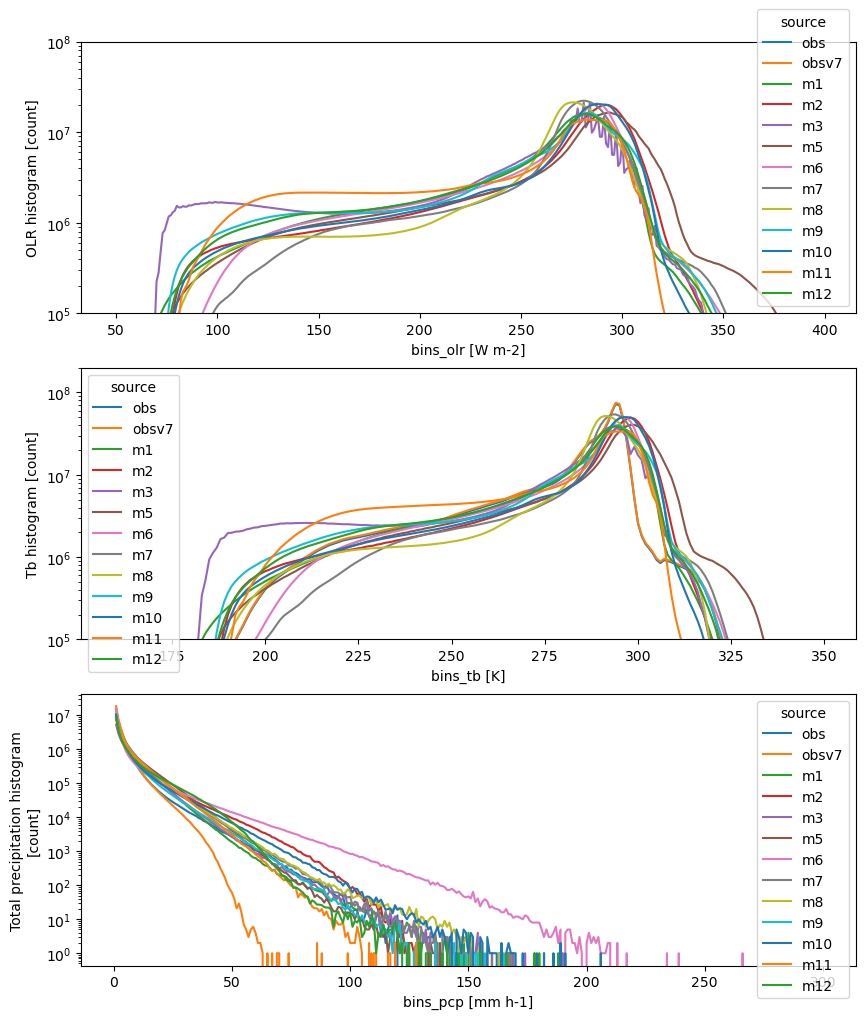

In [7]:
fig, axes = plt.subplots(3, 1, figsize=[10,12], dpi=100)

ax0 = axes[0]
xr.plot.line(dsr.olr, x='bins_olr', ax=ax0)
ax0.set_yscale('log')
ax0.set_ylim((1e5, 1e8))

ax1 = axes[1]
xr.plot.line(dsr.tb, x='bins_tb', ax=ax1)
ax1.set_yscale('log')
ax1.set_ylim((1e5, 2e8))

ax2 = axes[2]
xr.plot.line(dsr.total_pcp, x='bins_pcp', ax=ax2)
# ax1.set_xscale('log')
ax2.set_yscale('log')

## Add DPR histogram to combined data

In [8]:
# Expand the dimension of the DPR DataArrays
dprpcp_hist = ds_dpr.total_pcp_dpr.expand_dims(dim='source', axis=0).assign_coords(source=['dpr'])
dprmcspcp_hist = ds_dpr.mcs_pcp_dpr.expand_dims(dim='source', axis=0).assign_coords(source=['dpr'])
dprmcspcp_o_hist = ds_dpr.mcs_pcp_o_dpr.expand_dims(dim='source', axis=0).assign_coords(source=['dpr'])
dprmcspcp_l_hist = ds_dpr.mcs_pcp_l_dpr.expand_dims(dim='source', axis=0).assign_coords(source=['dpr'])

# Concatenate the expanded DPR DataArrays with the others
totpcp_hist = xr.concat([dprpcp_hist, dsr.total_pcp], dim='source')
mcspcp_hist = xr.concat([dprmcspcp_hist, dsr.mcs_pcp], dim='source')
mcspcp_o_hist = xr.concat([dprmcspcp_o_hist, dsr.mcs_pcp_o], dim='source')
mcspcp_l_hist = xr.concat([dprmcspcp_l_hist, dsr.mcs_pcp_l], dim='source')

# Make a new dictionary for pcp by adding 'dpr', and update obs
pcp_name_map = copy.deepcopy(name_map)
pcp_name_map['dpr'] = 'DPR'
pcp_name_map['obs'] = 'IMERGv6'
pcp_name_map['obsv7'] = 'IMERGv7'
print(pcp_name_map)

{'obs': 'IMERGv6', 'obsv7': 'IMERGv7', 'm1': 'ARPEGE', 'm2': 'IFS', 'm3': 'MPAS', 'm5': 'SAM', 'm6': 'UM', 'm7': 'GRIST', 'm8': 'SCREAM', 'm9': 'XSHiELD', 'm10': 'GEOS', 'm11': 'ICON', 'm12': 'SCREAMv1', 'dpr': 'DPR'}


## Divide histogram by total sample size to get PDF

In [9]:
tb_pdf = dsr.tb / dsr.tb.sum(dim='bins_tb')
# totpcp_pdf = dsr.total_pcp / dsr.total_pcp.sum(dim='bins_pcp')
totpcp_pdf = totpcp_hist / totpcp_hist.sum(dim='bins_pcp')

mcstb_pdf = dsr.mcs_tb / dsr.mcs_tb.sum(dim='bins_tb')
# mcspcp_pdf = dsr.mcs_pcp / dsr.mcs_pcp.sum(dim='bins_pcp')
mcspcp_pdf = mcspcp_hist / mcspcp_hist.sum(dim='bins_pcp')

mcspcp_o_pdf = mcspcp_o_hist / mcspcp_o_hist.sum(dim='bins_pcp')
mcspcp_l_pdf = mcspcp_l_hist / mcspcp_l_hist.sum(dim='bins_pcp')

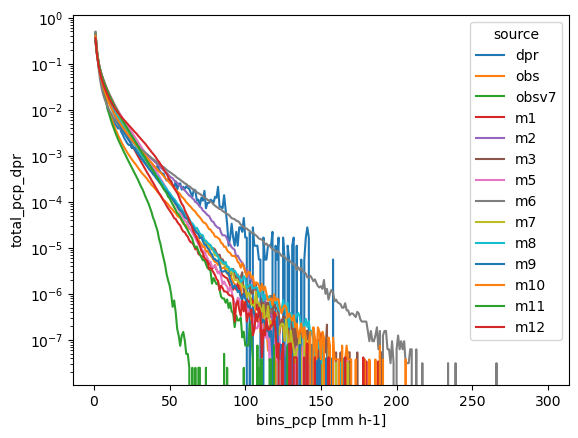

In [10]:
totpcp_pdf.plot.line(x='bins_pcp')
plt.yscale('log')

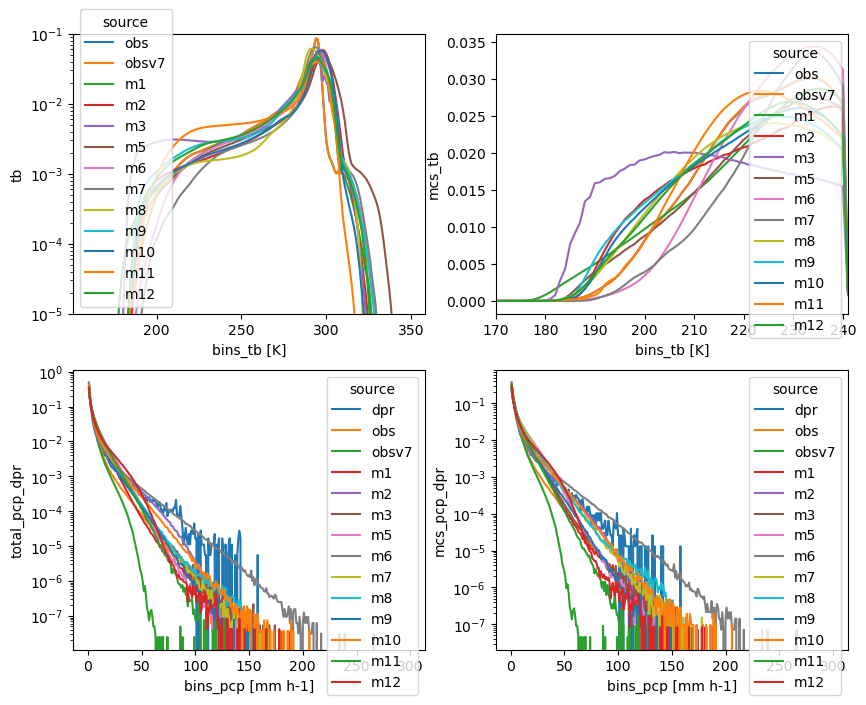

In [11]:
fig, axes = plt.subplots(2, 2, figsize=[10,8], dpi=100)

ax00 = axes[0][0]
xr.plot.line(tb_pdf, x='bins_tb', ax=ax00)
ax00.set_yscale('log')
ax00.set_ylim((1e-5, 1e-1))

ax10 = axes[1][0]
xr.plot.line(totpcp_pdf, x='bins_pcp', ax=ax10)
# ax10.set_xscale('log')
ax10.set_yscale('log')

ax01 = axes[0][1]
xr.plot.line(mcstb_pdf, x='bins_tb', ax=ax01)
ax01.set_xscale('linear')
ax01.set_yscale('linear')
ax01.set_xlim((170, 241))
# ax01.set_ylim((1e5, 1e8))

ax11 = axes[1][1]
xr.plot.line(mcspcp_pdf, x='bins_pcp', ax=ax11)
ax11.set_xscale('linear')
ax11.set_yscale('log')
# ax11.set_ylim((1e5, 2e8))

## Compute precipitation fractional contribution by rain rate

In [12]:
# Multiply histogram by bin value to get total amount of rain for each bin
totamt_hist = dsr.total_pcp * dsr.bins_pcp
mcsamt_hist = dsr.mcs_pcp * dsr.bins_pcp

# Get fractional contribution by dividing the sum of all rain bins
totamt_frac = totamt_hist / totamt_hist.sum(dim='bins_pcp')
mcsamt_frac = mcsamt_hist / mcsamt_hist.sum(dim='bins_pcp')

In [13]:
# fig, axes = plt.subplots(2, 1, figsize=[10,12], dpi=100)

# ax0 = axes[0]
# xr.plot.line(totamt_frac, x='bins_pcp', ax=ax0)
# ax0.set_xscale('log')
# ax0.set_yscale('linear')
# # ax0.set_ylim((1e5, 1e8))

# ax1 = axes[1]
# xr.plot.line(mcsamt_frac, x='bins_pcp', ax=ax1)
# ax1.set_xscale('log')
# ax1.set_yscale('linear')
# # ax1.set_ylim((1e5, 2e8))

In [14]:
# Multiply histogram by bin value to get total amount of rain for each bin
mcsamt_o_hist = mcspcp_o_hist * dsr.bins_pcp
mcsamt_l_hist = mcspcp_l_hist * dsr.bins_pcp

# Get fractional contribution by dividing the sum of all rain bins
mcsamt_o_frac = mcsamt_o_hist / mcsamt_o_hist.sum(dim='bins_pcp')
mcsamt_l_frac = mcsamt_l_hist / mcsamt_l_hist.sum(dim='bins_pcp')

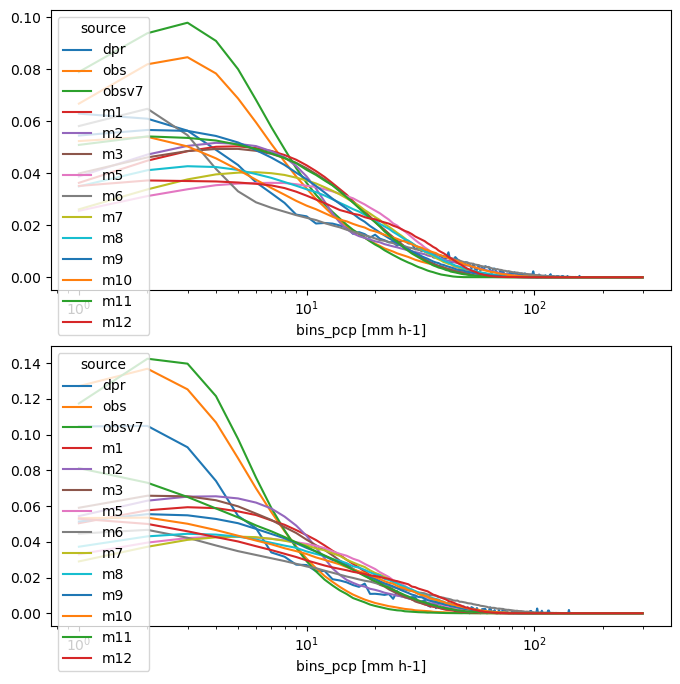

In [15]:
fig, axes = plt.subplots(2, 1, figsize=[8,8], dpi=100)

ax0 = axes[0]
xr.plot.line(mcsamt_o_frac, x='bins_pcp', ax=ax0)
ax0.set_xscale('log')
ax0.set_yscale('linear')
# ax0.set_ylim((1e5, 1e8))

ax1 = axes[1]
xr.plot.line(mcsamt_l_frac, x='bins_pcp', ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('linear')
# ax1.set_ylim((1e5, 2e8))

## Function to plot histograms

In [16]:
def plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,  
                    map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                    xscale=None, yscale=None, xlims=None, ylims=None, vspan=None, vspan_color=None,
                    wspace=None, hspace=None, xticks=None,
                    show_inset=None, inset_dict=None, legend_prop=None, fontsize=None, figsize=[10,10]):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    # fig, axes = plt.subplots(nrows=nrow, ncols=1, figsize=figsize, dpi=100)
    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, 1, wspace=wspace, hspace=hspace)
    # gs = gridspec.GridSpec(nrow, 1, left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=wspace, hspace=hspace)
    # gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=wspace, hspace=hspace)

    lw = 2
    lcolors = {
        'dpr': 'darkblue',
        'obs': 'k', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    # time_fmt = mdates.DateFormatter('%m/%d')

    for row in range(0, nrow):
        # ax = axes[row]
        ax = plt.subplot(gs[row])
        source_list = list(data_arr[row].source.data)
        for ss in source_list:
            if (ss == 'obs'):
                linewidth = lw*4
                linestyle = '-'
            elif (ss == 'dpr'):
                linewidth = lw*3
                linestyle = '-'
            elif ss == 'obsv7':
                linewidth = lw*1.5
                linestyle = '-'
            else:
                linewidth = lw
                linestyle = '-'
            # linewidth = lw*3 if 'obs' in ss else lw
            ax.plot(xx_data[row], data_arr[row].sel(source=ss), lcolors[ss], lw=linewidth, ls=linestyle, label=legends[row][ss])

        ax.tick_params(axis='x', labelsize=None)
        ax.set_title(titles[row], loc='left')
        ax.set_xlabel(xlabels[row])
        ax.set_ylabel(ylabels[row])
        if (xlims is not None): ax.set_xlim(xlims[row][0], xlims[row][1])
        if (ylims is not None): ax.set_ylim(ylims[row][0], ylims[row][1])
        if (xscale is not None): ax.set_xscale(xscale[row])
        if (yscale is not None): ax.set_yscale(yscale[row])
        if (xticks is not None):
            ax.set_xticks(xticks[row])
            ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.grid(which='major', ls='--')
        ax.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'])
        # Shade 
        if vspan is not None:
            ax.axvspan(vspan[row][0], vspan[row][1], facecolor=vspan_color, alpha=0.2, zorder=0)
            # ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
        
        if (show_inset[row]):
            x_sub = inset_dict['x_sub']
            y_sub = inset_dict['y_sub']
            yscale_sub = inset_dict['yscale']
            xscale_sub = inset_dict['xscale']
            xticks_sub = inset_dict['xticks']
            box_color = inset_dict['box_color']
            line_width = inset_dict['line_width']
            width = inset_dict['width']
            height = inset_dict['height']
            loc = inset_dict['loc']
            borderpad = inset_dict['borderpad']
            # Create the inset plot
            axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)

            # Plot the inset plot data
            for ss in source_list:
                if ss == 'obs':
                    linewidth = lw*2
                elif (ss == 'dpr'):
                    linewidth = lw*2
                elif ss == 'obsv7':
                    linewidth = lw*1
                else:
                    linewidth = lw*0.7
                # linewidth = lw*3 if 'obs' in ss else lw
                axins.plot(xx_data[row], data_arr[row].sel(source=ss), lcolors[ss], lw=linewidth, label=legends[row][ss])
            axins.set_xlim(x_sub[0], x_sub[1])
            axins.set_ylim(y_sub[0], y_sub[1])
            if (xscale_sub is not None): axins.set_xscale(xscale_sub[row])
            if (yscale_sub is not None): axins.set_yscale(yscale_sub[row])
            axins.set_xlabel(xlabels[row])
            axins.set_xticks(xticks_sub)
            axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            axins.grid(which='major', ls='--')

            # Add rectangle indicating the zoomed region in the main plot
            rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
            ax.add_patch(rect)

    # fig.autofmt_xdate()
    # fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

    return fig

In [17]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)']
panel_numbers

['(b)', '(d)']

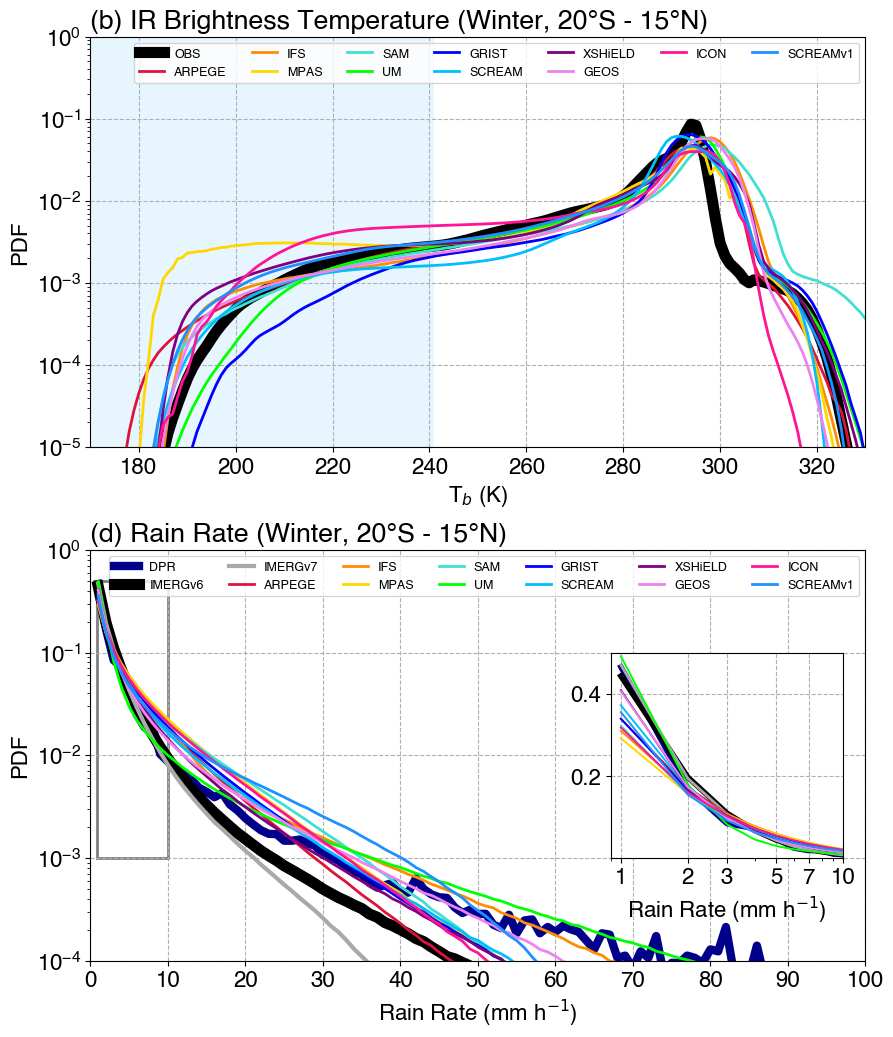

In [18]:
# data_arr = [tb_pdf, totpcp_pdf]
tb_pdf_new = tb_pdf.drop_sel(source='obsv7')
tb_name_map = tb_pdf_new.source
data_arr = [tb_pdf_new, totpcp_pdf]
xx_data = [dsr.bins_tb, dsr.bins_pcp]
nrow = len(data_arr)

if (PHASE == 'Summer'): y_sub = (1e-3, 0.5)
if (PHASE == 'Winter'): y_sub = (1e-3, 0.5)
inset_dict = {
    # 'x_sub': (0.9, 15),
    'x_sub': (0.9, 10),
    'y_sub': y_sub,
    'xscale': ['log']*2,
    'yscale': ['linear']*2,
    # 'xticks': [1, 2, 3, 5, 7, 10, 15],
    'xticks': [1, 2, 3, 5, 7, 10,],
    'box_color': 'gray',
    'line_width': 2,
    'width': '30%',
    'height': '50%',
    'loc': 'center right',
    'borderpad': 1,
}

# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
titles = [
    f'{panel_numbers[0]} IR Brightness Temperature ({PHASE}, {lat_min} - {lat_max})', 
    f'{panel_numbers[1]} Rain Rate ({PHASE}, {lat_min} - {lat_max})', 
]
ylabels = ['PDF', 'PDF',]
xlabels = ['T$_b$ (K)', 'Rain Rate (mm h$^{-1}$)']
xlims = [(170,330), (0, 100)]
# ylims = [(1e-5, 1), (1e-6, 1)]
ylims = [(1e-5, 1), (1e-4, 1)]
# ylims = None
xticks = [np.arange(180,321,20), np.arange(0,101,10)]
vspan = [(170, 241), (None, None)]
vspan_color = 'lightskyblue'
# vspan = [(241, 350), (None, None)]
# vspan_color = 'moccasin'
xscale = None
yscale = ['log', 'log']
show_inset = [False, True]
legends_tb = name_map
legends_pcp = pcp_name_map
legends = [name_map, pcp_name_map]
legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':9, 'loc':'best'}
wspace = 0.0
hspace = 0.25
fontsize = 16
figname = f'{figdir}global_tb_pcp_pdf.png'
fig = plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,
                     xlims=xlims, ylims=ylims, vspan=vspan, vspan_color=vspan_color, xscale=xscale, yscale=yscale,
                     show_inset=show_inset, inset_dict=inset_dict, wspace=wspace, hspace=hspace, xticks=xticks,
                     legend_prop=legend_prop, fontsize=fontsize, figsize=[10,12])

In [19]:
# data_arr = [dsr.tb, dsr.total_pcp]
# xx_data = [dsr.bins_tb, dsr.bins_pcp]
# nrow = len(data_arr)

# if (PHASE == 'Summer'): y_sub = (1e4, 0.5e8)
# if (PHASE == 'Winter'): y_sub = (1e4, 0.25e8)
# inset_dict = {
#     'x_sub': (0.9, 15),
#     'y_sub': y_sub,
#     'xscale': ['log']*2,
#     'yscale': ['linear']*2,
#     'xticks': [1, 2, 3, 5, 7, 10, 15],
#     'box_color': 'gray',
#     'line_width': 2,
#     'width': '30%',
#     'height': '55%',
#     'loc': 'center right',
#     'borderpad': 1,
# }

# # Make lat bound formats for plotting
# lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
# lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
# titles = [
#     f'{panel_numbers[0]} IR Brightness Temperature ({PHASE}, {lat_min} - {lat_max})', 
#     f'{panel_numbers[1]} Rain Rate ({PHASE}, {lat_min} - {lat_max})', 
# ]
# ylabels = ['Histogram (counts)', 'Histogram (counts)',]
# xlabels = ['T$_b$ (K)', 'Rain Rate (mm h$^{-1}$)']
# xlims = [(180,330), (0, 200)]
# ylims = [(1e5, 3e8), (10,1e8)]
# # ylims = None
# vspan = [(180, 241), (None, None)]
# vspan_color = 'lightskyblue'
# # vspan = [(241, 350), (None, None)]
# # vspan_color = 'moccasin'
# xscale = None
# yscale = ['log', 'log']
# show_inset = [False, True]
# # legends = name_map
# legends_tb = name_map
# legends_pcp = pcp_name_map
# legends = [name_map, pcp_name_map]
# legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':9, 'loc':'best'}
# wspace = 0.0
# hspace = 0.25
# fontsize = 16
# figname = f'{figdir}global_tb_pcp_hist.png'
# fig = plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,
#                      xlims=xlims, ylims=ylims, vspan=vspan, vspan_color=vspan_color, xscale=xscale, yscale=yscale,
#                      show_inset=show_inset, inset_dict=inset_dict, wspace=wspace, hspace=hspace,
#                      legend_prop=legend_prop, fontsize=fontsize, figsize=[10,12])

In [20]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/global_tb_pcp_pdf.png'

In [21]:
# mcstb_pdf.sel(source='m12').plot()

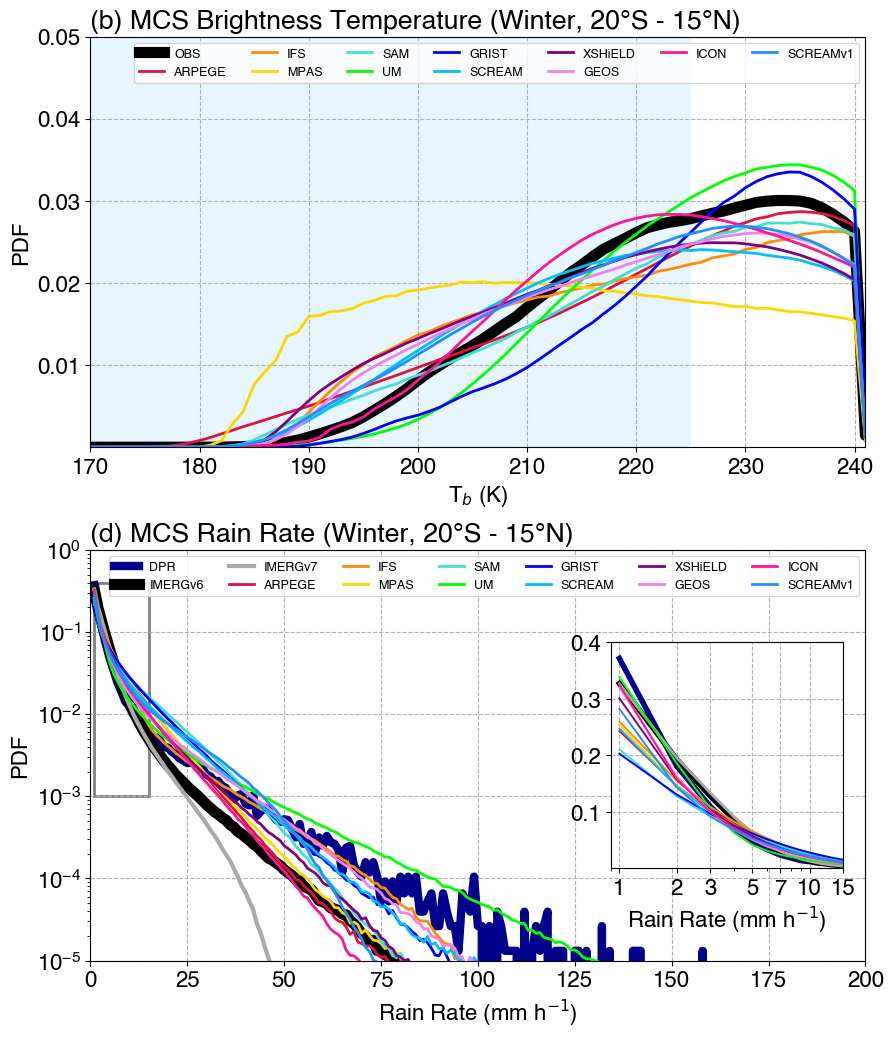

In [22]:
# data_arr = [mcstb_pdf, mcspcp_pdf]
mcstb_pdf_new = mcstb_pdf.drop_sel(source='obsv7')
data_arr = [mcstb_pdf_new, mcspcp_pdf]
xx_data = [dsr.bins_tb, dsr.bins_pcp]
nrow = len(data_arr)

if (PHASE == 'Summer'): y_sub = (1e-3, 0.4)
if (PHASE == 'Winter'): y_sub = (1e-3, 0.4)
inset_dict = {
    'x_sub': (0.9, 15),
    'y_sub': y_sub,
    'xscale': ['log']*2,
    'yscale': ['linear']*2,
    'xticks': [1, 2, 3, 5, 7, 10, 15],
    'box_color': 'gray',
    'line_width': 2,
    'width': '30%',
    'height': '55%',
    'loc': 'center right',
    'borderpad': 1,
}

# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
titles = [
    f'{panel_numbers[0]} MCS Brightness Temperature ({PHASE}, {lat_min} - {lat_max})', 
    f'{panel_numbers[1]} MCS Rain Rate ({PHASE}, {lat_min} - {lat_max})', 
]
ylabels = ['PDF', 'PDF',]
xlabels = ['T$_b$ (K)', 'Rain Rate (mm h$^{-1}$)']
xlims = [(170,241), (0, 200)]
ylims = [(1e-5, 0.05), (1e-5, 1)]
# ylims = None
vspan = [(160, 225), (None, None)]
vspan_color = 'lightskyblue'
# vspan = [(241, 350), (None, None)]
# vspan_color = 'moccasin'
xscale = None
yscale = ['linear', 'log']
show_inset = [False, True]
# legends = name_map
legends_tb = name_map
legends_pcp = pcp_name_map
legends = [name_map, pcp_name_map]
legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':9, 'loc':'best'}
wspace = 0.0
hspace = 0.25
fontsize = 16
figname = f'{figdir_tracker}global_tb_pcp_pdf_{tracker}.png'
fig = plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,
                     xlims=xlims, ylims=ylims, vspan=vspan, vspan_color=vspan_color, xscale=xscale, yscale=yscale,
                     show_inset=show_inset, inset_dict=inset_dict, wspace=wspace, hspace=hspace,
                     legend_prop=legend_prop, fontsize=fontsize, figsize=[10,12])

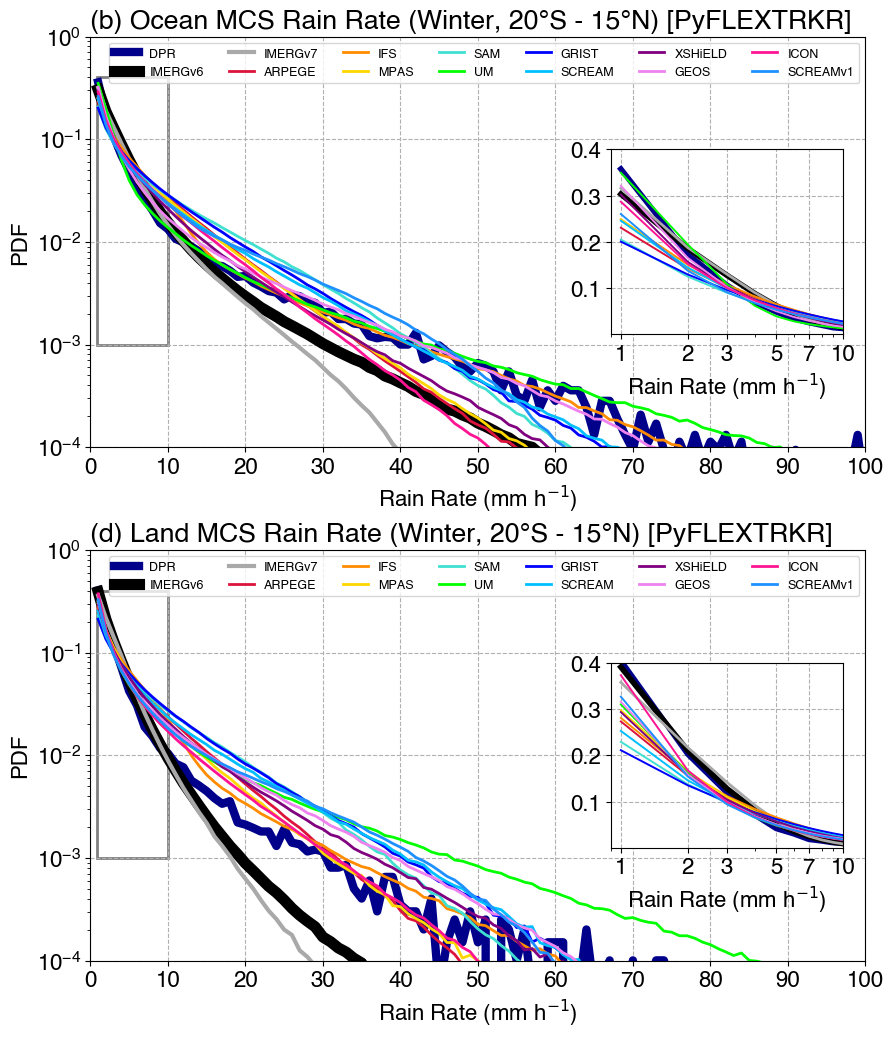

In [23]:
data_arr = [mcspcp_o_pdf, mcspcp_l_pdf]
xx_data = [dsr.bins_pcp, dsr.bins_pcp]
nrow = len(data_arr)

inset_dict = {
    'x_sub': (0.9, 10),
    'y_sub': (1e-3, 0.4),
    'xscale': ['log']*2,
    'yscale': ['linear']*2,
    'xticks': [1, 2, 3, 5, 7, 10],
    'box_color': 'gray',
    'line_width': 2,
    'width': '30%',
    'height': '45%',
    'loc': 'center right',
    'borderpad': 1,
}

# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
titles = [
    f'{panel_numbers[0]} Ocean MCS Rain Rate ({PHASE}, {lat_min} - {lat_max}) [{tracker}]', 
    f'{panel_numbers[1]} Land MCS Rain Rate ({PHASE}, {lat_min} - {lat_max}) [{tracker}]', 
]
ylabels = ['PDF', 'PDF',]
xlabels = ['Rain Rate (mm h$^{-1}$)', 'Rain Rate (mm h$^{-1}$)']
xlims = [(0,100), (0,100)]
ylims = [(1e-4, 1), (1e-4, 1)]
xticks = [np.arange(0,101,10)]*2
vspan = [(None, None), (None, None)]
vspan_color = 'lightskyblue'
# vspan = [(241, 350), (None, None)]
# vspan_color = 'moccasin'
xscale = ['linear', 'linear']
yscale = ['log', 'log']
show_inset = [True, True]
legends_pcp = pcp_name_map
legends = [pcp_name_map, pcp_name_map]
legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':9, 'loc':'best'}
# legend_prop = {'ncol':1, 'fontsize':10, 'loc':'best'}
wspace = 0.0
hspace = 0.25
fontsize = 16
figname = f'{figdir_tracker}global_mcs_pcp_pdf_ocean_land_{tracker}.png'
fig = plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,
                     xlims=xlims, ylims=ylims, vspan=vspan, vspan_color=vspan_color, xscale=xscale, yscale=yscale,
                     show_inset=show_inset, inset_dict=inset_dict, wspace=wspace, hspace=hspace, xticks=xticks,
                     legend_prop=legend_prop, fontsize=fontsize, figsize=[10,12])

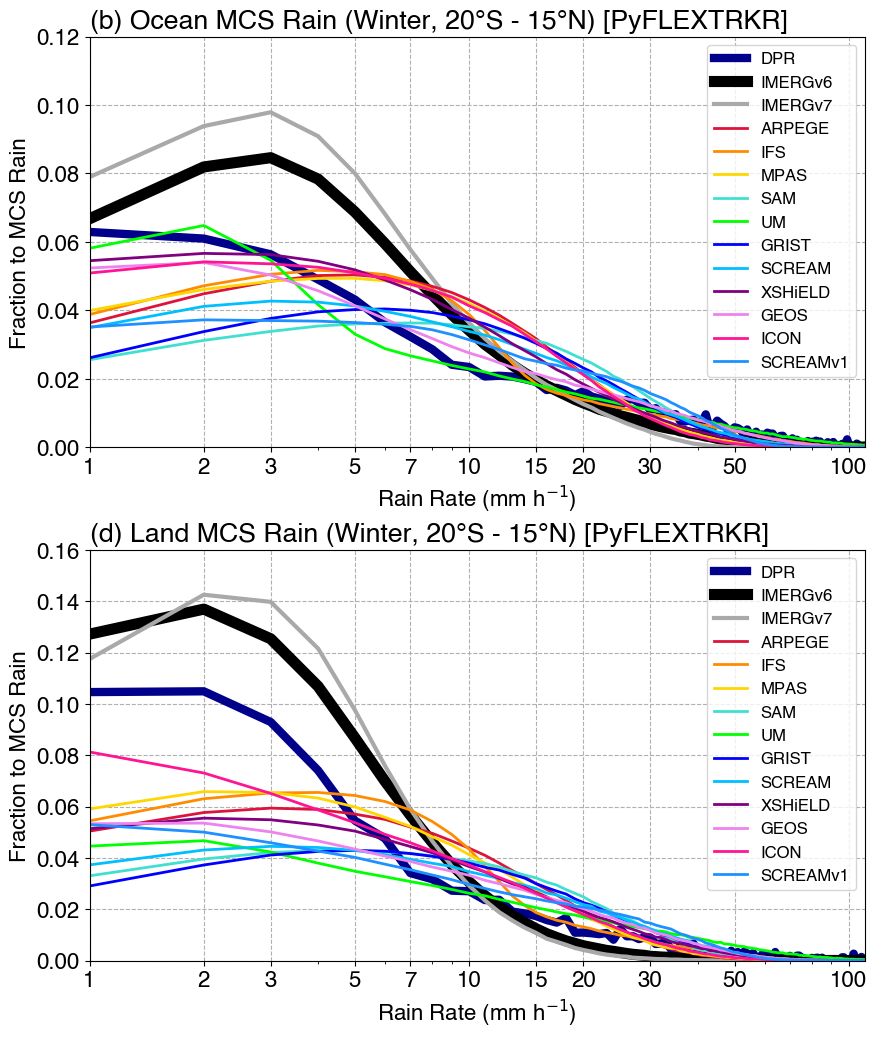

In [24]:
data_arr = [mcsamt_o_frac, mcsamt_l_frac]
xx_data = [dsr.bins_pcp, dsr.bins_pcp]
nrow = len(data_arr)

# if (PHASE == 'Summer'): y_sub = (1e-4, 0.08)
# if (PHASE == 'Winter'): y_sub = (1e-4, 0.08)
inset_dict = {
    'x_sub': (10, 100),
    'y_sub': (1e-4, 0.05),
    'xscale': ['linear']*2,
    'yscale': ['log']*2,
    'xticks': [10,25,50,75,100],
    'box_color': 'gray',
    'line_width': 2,
    'width': '30%',
    'height': '40%',
    'loc': 'center right',
    'borderpad': 1,
}

# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
titles = [
    f'{panel_numbers[0]} Ocean MCS Rain ({PHASE}, {lat_min} - {lat_max}) [{tracker}]', 
    f'{panel_numbers[1]} Land MCS Rain ({PHASE}, {lat_min} - {lat_max}) [{tracker}]', 
]
ylabels = ['Fraction to MCS Rain', 'Fraction to MCS Rain',]
xlabels = ['Rain Rate (mm h$^{-1}$)', 'Rain Rate (mm h$^{-1}$)']
xlims = [(1,110), (1, 110)]
ylims = [(0, 0.12), (0, 0.16)]
# ylims = None
xticks = [[1,2,3,5,7,10,15,20,30,50,100]]*2
vspan = [(None, None), (None, None)]
vspan_color = 'lightskyblue'
# vspan = [(241, 350), (None, None)]
# vspan_color = 'moccasin'
xscale = ['log', 'log']
yscale = ['linear', 'linear']
show_inset = [False, False]
legends_pcp = pcp_name_map
legends = [pcp_name_map, pcp_name_map]
# legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':9, 'loc':'best'}
legend_prop = {'ncol':1, 'fontsize':12, 'loc':'best'}
wspace = 0.0
hspace = 0.25
fontsize = 16
figname = f'{figdir_tracker}global_mcs_pcp_fractional_pdf_ocean_land_{tracker}.png'
fig = plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,
                     xlims=xlims, ylims=ylims, vspan=vspan, vspan_color=vspan_color, xscale=xscale, yscale=yscale,
                     show_inset=show_inset, inset_dict=inset_dict, wspace=wspace, hspace=hspace, xticks=xticks,
                     legend_prop=legend_prop, fontsize=fontsize, figsize=[10,12])

In [25]:
# data_arr = [totamt_frac, mcsamt_frac]
# xx_data = [dsr.bins_pcp, dsr.bins_pcp]
# nrow = len(data_arr)

# if (PHASE == 'Summer'): y_sub = (1e-4, 0.08)
# if (PHASE == 'Winter'): y_sub = (1e-4, 0.08)
# inset_dict = {
#     'x_sub': (10, 100),
#     'y_sub': y_sub,
#     'xscale': ['linear']*2,
#     'yscale': ['log']*2,
#     'xticks': [10,25,50,75,100],
#     'box_color': 'gray',
#     'line_width': 2,
#     'width': '30%',
#     'height': '55%',
#     'loc': 'center right',
#     'borderpad': 1,
# }

# # Make lat bound formats for plotting
# lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
# lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
# titles = [
#     f'{panel_numbers[0]} Total Rain ({PHASE}, {lat_min} - {lat_max})', 
#     f'{panel_numbers[1]} MCS Rain ({PHASE}, {lat_min} - {lat_max})', 
# ]
# ylabels = ['Fraction to Total Amount', 'Fraction to Total Amount',]
# xlabels = ['Rain Rate (mm h$^{-1}$)', 'Rain Rate (mm h$^{-1}$)']
# xlims = [(1,200), (1, 200)]
# ylims = [(0, 0.18), (0, 0.13)]
# # ylims = None
# xticks = [1,2,3,5,7,10,15,20,30,50,100,200]
# vspan = [(None, None), (None, None)]
# vspan_color = 'lightskyblue'
# # vspan = [(241, 350), (None, None)]
# # vspan_color = 'moccasin'
# xscale = ['log', 'log']
# yscale = ['linear', 'linear']
# show_inset = [True, True]
# # legends = name_map
# legends_tb = name_map
# legends_pcp = pcp_name_map
# legends = [name_map, pcp_name_map]
# legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':9, 'loc':'best'}
# wspace = 0.0
# hspace = 0.25
# fontsize = 16
# figname = f'{figdir_tracker}global_total_mcs_pcp_fractional_pdf_{tracker}.png'
# fig = plot_hist_nrow(nrow, xx_data, data_arr, titles, xlabels, ylabels, legends, figname,
#                      xlims=xlims, ylims=ylims, vspan=vspan, vspan_color=vspan_color, xscale=xscale, yscale=yscale,
#                      show_inset=show_inset, inset_dict=inset_dict, wspace=wspace, hspace=hspace, xticks=xticks,
#                      legend_prop=legend_prop, fontsize=fontsize, figsize=[10,12])

In [26]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/PyFLEXTRKR/global_mcs_pcp_fractional_pdf_ocean_land_PyFLEXTRKR.png'